# Doing Bayesian Analysis Exercise 7
Martin Popovski 186086

## Imports

In [72]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, uniform

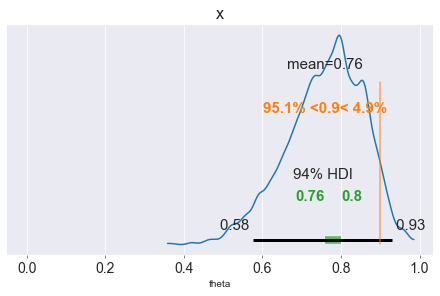

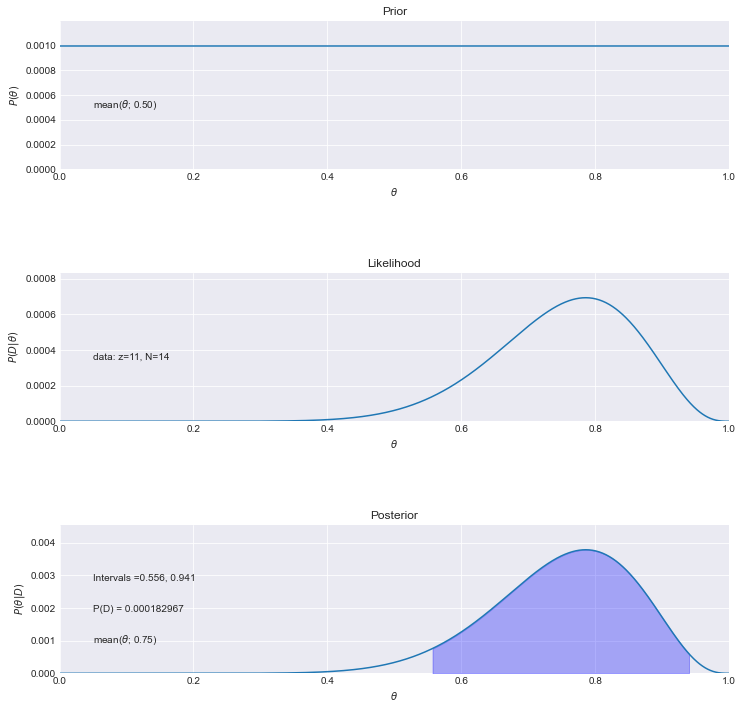

In [2]:
bern_metropolis_template = __import__('Doing_bayesian_data_analysis-master.07_BernMetropolisTemplate', fromlist=['likelihood', 'prior', 'target_rel_prob'])
bern_grid = __import__('Doing_bayesian_data_analysis-master.06_BernGrid', fromlist=['bern_grid'])

## Exercise 7.1
**[Purpose: To see what happens in the Metropolis algorithm with different proposal
distributions, and to get a sense how the proposal distribution must be “tuned” to the target distribution.]**  
Use the home-grown Metropolis algorithm in the R script of Section 7.6.1
(BernMetropolisTemplate.R) for this exercise. See Figure 7.6 for examples of what your
output might look like.

### Helper functions

In [3]:
def generate_random_walk(data, traj_length, burn_in=0, start=0.5, mean=0, stdev=0.1, random_state=None):
    if random_state:
        # Specify seed to reproduce same random walk:
        np.random.seed(random_state)
    # Initialize the vector that will store the results:
    trajectory = np.zeros(traj_length)
    # Specify where to start the trajectory:
    trajectory[0] = start # arbitrary value
    # Now generate the random walk. The 't' index is time or trial in the walk.
    # Initialize accepted, rejected counters, just to monitor performance:
    n_accepted = 0
    n_rejected = 0
    for t in range(traj_length-1):
        current_position = trajectory[t]
        # Use the proposal distribution to generate a proposed jump.
        # The shape and variance of the proposal distribution can be changed
        # to whatever you think is appropriate for the target distribution.
        proposed_jump = np.random.normal(loc=mean , scale=stdev, size=1)
        
        # Compute the probability of accepting the proposed jump.
        prob_accept = np.minimum(1, 
                                bern_metropolis_template.target_rel_prob(current_position + proposed_jump, data)
                                / bern_metropolis_template.target_rel_prob(current_position, data))
        # Generate a random uniform value from the interval [0,1] to
        # decide whether or not to accept the proposed jump.
        if np.random.rand() < prob_accept:
            # accept the proposed jump
            trajectory[t+1] = current_position + proposed_jump
            # increment the accepted counter, just to monitor performance
            if t > burn_in:
                n_accepted += 1
        else:
            # reject the proposed jump, stay at current position
            trajectory[t+1] = current_position
            # increment the rejected counter, just to monitor performance
            if t > burn_in:
                n_rejected += 1


    # Extract the post-burn_in portion of the trajectory.
    accepted_traj = trajectory[burn_in:]
    # End of Metropolis algorithm.
    return accepted_traj, n_accepted, n_rejected

In [45]:
def plot_random_walk(data, accepted_traj, n_accepted, n_rejected, prior_func=None, a=None, b=None):
    if prior_func is None:
        prior_func = bern_metropolis_template.prior
    # Display the posterior.
    ROPE = np.array([0.76, 0.8])
    pm.plot_posterior(accepted_traj, ref_val=0.9, rope=ROPE)
    plt.xlabel('theta')

    # Display rejected/accepted ratio in the plot.
    mean_traj = np.mean(accepted_traj)
    std_traj = np.std(accepted_traj)
    # plt.text(0, 0, r'$N_{pro}=%s$ $\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(accepted_traj), (n_accepted/len(accepted_traj))), fontsize=14, verticalalignment='top', horizontalalignment='left')
    print('N(pro) = %s ; N(acc) / N(pro) = %.3f' % (len(accepted_traj), (n_accepted/len(accepted_traj))))
    # Evidence for model, p(D).

    # Compute a,b parameters for beta distribution that has the same mean
    # and stdev as the sample from the posterior. This is a useful choice
    # when the likelihood function is Bernoulli.
    if a is None:
        a =   mean_traj   * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)
    if b is None:
        b = (1 - mean_traj) * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)

    # For every theta value in the posterior sample, compute 
    # dbeta(theta,a,b) / likelihood(theta)*prior(theta)
    # This computation assumes that likelihood and prior are proper densities,
    # i.e., not just relative probabilities. This computation also assumes that
    # the likelihood and prior functions were defined to accept a vector argument,
    # not just a single-component scalar argument.
    wtd_evid = beta.pdf(accepted_traj, a, b) / (bern_metropolis_template.likelihood(accepted_traj, data) * prior_func(accepted_traj))
    p_data = 1 / np.mean(wtd_evid)

    # Display p(D) in the graph
    # plt.text(0, 0, 'p(D) = %.3e' % p_data, fontsize=14, verticalalignment='top', horizontalalignment='left')
    print('p(D) = %.3e' % p_data)
    # Uncomment next line if you want to save the graph.
    # plt.savefig('BernMetropolisTemplate.png')
    # plt.show()
    return wtd_evid

### (A)
The proposal distribution generates candidate jumps that are normally distributed
with mean zero. Set the standard deviation of the proposal distribution to 0.1 (if it isn’t
already) and run the script. Save/print the graph and annotate it with SD=0.1.

N(pro) = 4500 ; N(acc) / N(pro) = 0.711
p(D) = 1.813e-04


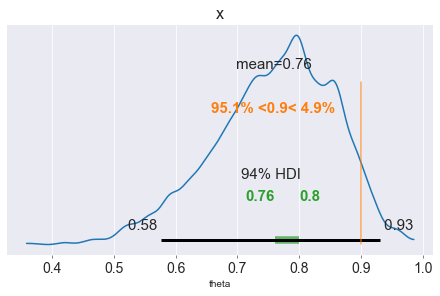

In [20]:
data_coin_flips = np.repeat([1, 0], [11, 3])  # 11 heads, 3 tail
traj_length = 5000
burn_in = int(np.ceil(0.1 * traj_length))
start = 0.5

accepted_traj, n_accepted, n_rejected = generate_random_walk(
    data_coin_flips,
    traj_length=traj_length,
    burn_in=burn_in,
    start=start,
    mean=0,
    stdev=0.1,
    random_state=4745
)

plot_random_walk(data_coin_flips, accepted_traj, n_accepted, n_rejected)

### (B)
Set the standard deviation of the proposal distribution to 0.001 and run the script.
Save/print the graph and annotate it with SD=0.001.

N(pro) = 4500 ; N(acc) / N(pro) = 0.994
p(D) = 2.127e-05


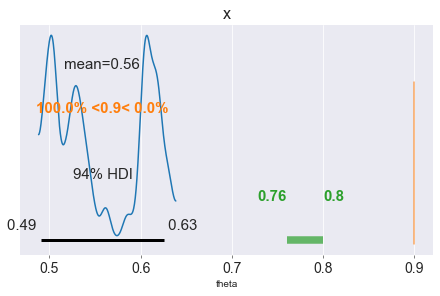

In [11]:
data_coin_flips = np.repeat([1, 0], [11, 3])  # 11 heads, 3 tail
traj_length = 5000
burn_in = int(np.ceil(0.1 * traj_length))
start = 0.5

accepted_traj, n_accepted, n_rejected = generate_random_walk(
    data_coin_flips,
    traj_length,
    burn_in=burn_in,
    start=start,
    mean=0,
    stdev=0.001,
    random_state=4745
)

plot_random_walk(data_coin_flips, accepted_traj, n_accepted, n_rejected)

### (C)
Set the standard deviation of the proposal distribution to 100.0 and run the script.
Save/print the graph and annotate it with SD=100.0.

N(pro) = 4500 ; N(acc) / N(pro) = 0.001
p(D) = 1.077e-04


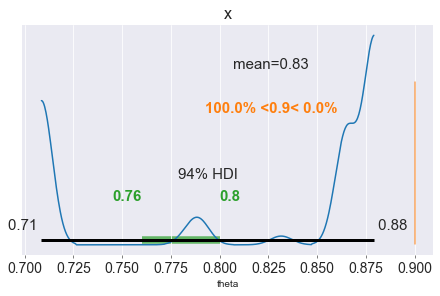

In [7]:
data_coin_flips = np.repeat([1, 0], [11, 3])  # 11 heads, 3 tail
traj_length = 5000
burn_in = int(np.ceil(0.1 * traj_length))
start = 0.5

accepted_traj, n_accepted, n_rejected = generate_random_walk(
    data_coin_flips,
    traj_length,
    burn_in=burn_in,
    start=start,
    mean=0,
    stdev=100.0,
    random_state=4745
)

plot_random_walk(data_coin_flips, accepted_traj, n_accepted, n_rejected)

### (D)
Which proposal distribution gave the most accurate representation of the posterior?
Which proposal distribution had the fewest rejected proposals? Which proposal distribution
had the most rejected proposals?

(A) gave the most accurate representation of the posterior.  
(B) had the fewest rejected proposals.  
(C) had the most rejected proposals.

### (E)
If we didn’t know from other techniques what the true posterior looked like, how
would we know which proposal distribution generated the most accurate representation of
the posterior? (This does not have a quick answer; it’s meant mostly as a question for
pondering and motivating techniques introduced in later chapters.)

...

## Exercise 7.2
**[Purpose: To understand the influence of the starting point of the random
walk, and why the walk doesn‘t necessarily go back to that region.]**  
Edit the homegrown Metropolis algorithm of Section 7.6.1 (BernMetropolisTemplate.R) for this exercise. It is
best to save it as a differently named script so you don‘t mess up the original version. Set
trajlength = 100 and set burnin = ceiling(0.01 *trajlength). Finally, set trajectory[1] =
0.001. Now run the script and save the resulting histogram.

### (A)
How many jumps are proposed? How
many steps are excluded as part of the burn-in
portion? At what value of does the random
walk start?

Proposed jumps: 100
Excluded steps: 1
Random walk start: 0.001
N(pro) = 99 ; N(acc) / N(pro) = 0.636
p(D) = 4.595e-30


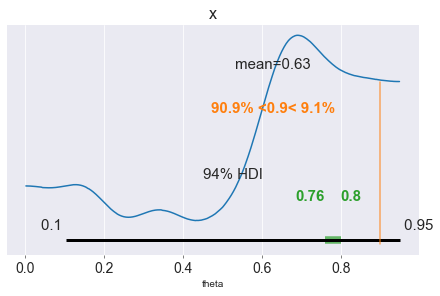

In [8]:
data_coin_flips = np.repeat([1, 0], [11, 3])  # 11 heads, 3 tail
traj_length = 100 # arbitrary large number
burn_in = int(np.ceil(0.01 * traj_length)) # arbitrary number, less than traj_length
start = 0.001

accepted_traj, n_accepted, n_rejected = generate_random_walk(
    data_coin_flips,
    traj_length=traj_length,
    burn_in=burn_in,
    start=start,
    mean=0,
    stdev=0.1,
    random_state=4745
)

print(f'Proposed jumps: {traj_length}')
print(f'Excluded steps: {burn_in}')
print(f'Random walk start: {accepted_traj[0]}')

plot_random_walk(data_coin_flips, accepted_traj, n_accepted, n_rejected)

### (B)
Why does the histogram have so many points below θ = 0.5? That is, why does the
chain stay below θ = 0.5 as long as it does?

Because the chain starts at the far left at 0.01. Also it has a fairly small stdev of 0.1.

### (C)
Why does the histogram have so few points below θ = 0.5? That is, why does the
chain not go back below 0.5?

The chain goes to the right because the posterior probabilities to the left are small.

## Exercise 7.3
**[Purpose: To get some hands-on experience with applying the Metropolis algorithm,
and to compare its results with the other methods we’ve learned about.]**  
Suppose you have a coin
that you believe is either fair, or biased to come up heads, or biased to come up tails. As
an expression of your prior belief, you define your prior on θ (the probability of heads) to
be proportional to [cos(4πθ) + 1]^2
. In other words, p(θ) = [cos(4πθ) + 1]^2
/Z, where Z is
the appropriate normalizing constant. We flip the coin 12 times and we get 8 heads. See Figure 7.7 to see the prior, likelihood, and posterior.

### (A)
Determine the formula for the posterior distribution exactly, using formal integration in Bayes’ rule. Just kidding. Instead, do the following: Explain the initial set up if you
wanted to try to determine the exact formula for the posterior. Show the explicit formulas
involving the likelihood and prior in Bayes’ rule. Do you think that the prior and likelihood are conjugate, that is, would the formula for the posterior have the “same form” as the
formula for the prior?

The posteriour probability probably doesn't have a trivial analytical solution. The formula for the posterior would most likely not have the same form as the formula for the prior.

### (B)
Use a fine grid over θ and approximate the posterior. Use the R function of Section 6.7.1 (BernGrid.R), p. 90. (The R function also plots the prior distribution, so you can
see that it really is trimodal.)

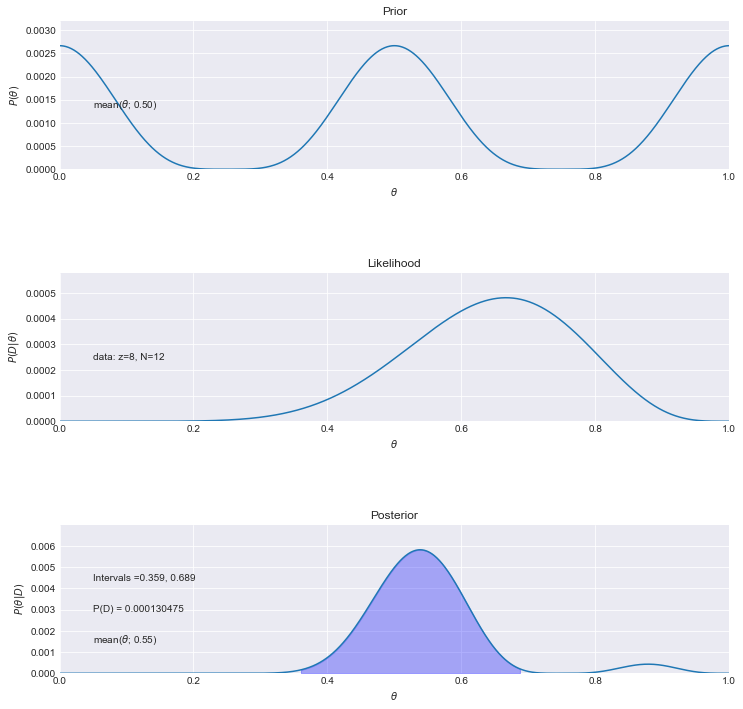

In [9]:
###Create vector of theta values.
bin_width = 1 / 1000
theta_grid = np.arange(bin_width / 2, 1 - bin_width / 2, bin_width)

##Specify probability mass at each theta value.
rel_prob = (np.cos(theta_grid * 4 * np.pi) + 1) ** 2
prior = rel_prob / sum(rel_prob)  # probability mass at each theta

###Specify the data vector.
data_vec = np.repeat([1, 0], [8, 4])  # 8 heads, 4 tails
###Call the function.
posterior = bern_grid.bern_grid(theta=theta_grid, p_theta=prior, data=data_vec)

### (C)
Use a Metropolis algorithm to approximate the posterior. Use the R script of Section 7.6.1 (BernMetropolisTemplate.R), adapted appropriately for the prior function. You’ll
need to alter the definitions of the likelihood and prior functions in the R script; include that
portion of the code with what you hand in (but don’t include the rest of the code). Must you
normalize the prior to generate a sample from the posterior? Is the value of p(D) displayed
in the graph correct?

N(pro) = 10000 ; N(acc) / N(pro) = 0.756
p(D) = 1.092e-14


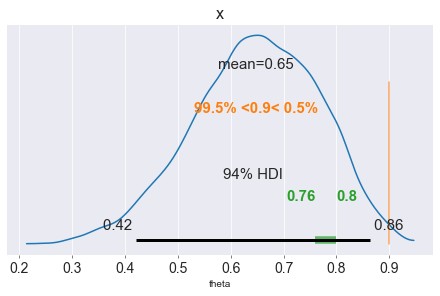

In [26]:
data_coin_flips = np.repeat([1, 0], [8, 4])  # 8 heads, 4 tail
traj_length = 11000 # arbitrary large number
burn_in = 1000 # arbitrary number, less than traj_length
start = 0.1

accepted_traj, n_accepted, n_rejected = generate_random_walk(
    data_coin_flips,
    traj_length=traj_length,
    burn_in=burn_in,
    start=start,
    mean=0,
    stdev=0.1,
    random_state=4745
)

def prior_func(theta):
    if not isinstance(theta, np.ndarray):
        theta = np.array([theta])
    prior = (np.cos(theta * 4 * np.pi) + 1) ** 2
    prior[(theta < 0) | (theta > 1)] = 1
    return prior if len(prior) > 1 else prior[0]


plot_random_walk(data_coin_flips, accepted_traj, n_accepted, n_rejected, prior_func)

### (D)
Could you apply BUGS to this situation? In particular, can you think of a way to
specify the prior density in terms of distributions that BUGS knows about?

...

## Exercise 7.4
**[Purpose: For approximating p(D), explore other choices for h(θ) in Equation 7.8, and
note that the one used in the R script of Section 7.6.1 (BernMetropolisTemplate.R) is a good one.]**  
Edit
the R script of Section 7.6.1 (BernMetropolisTemplate.R) for this exercise. Best to save it as
a differently named script so you don’t mess up the original version. At the very end of the
script, add this line: windows() ; plot(wtdEvid,type="l")


### (A)
Select (i.e., highlight with the cursor) that line in the R editor and run it. Save the
plot. Explain what the plot is plotting. That is, what is wtdEvid (on the y-axis) and what is
on the x-axis?

N(pro) = 4500 ; N(acc) / N(pro) = 0.711
p(D) = 1.813e-04


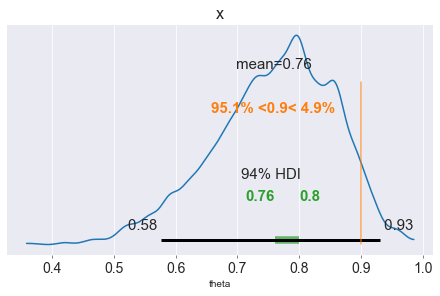

In [35]:
data_coin_flips = np.repeat([1, 0], [11, 3])  # 11 heads, 3 tail
traj_length = 5000
burn_in = int(np.ceil(0.1 * traj_length))
start = 0.5

accepted_traj, n_accepted, n_rejected = generate_random_walk(
    data_coin_flips,
    traj_length=traj_length,
    burn_in=burn_in,
    start=start,
    mean=0,
    stdev=0.1,
    random_state=4745
)

wtd_evid = plot_random_walk(data_coin_flips, accepted_traj, n_accepted, n_rejected)

<AxesSubplot:>

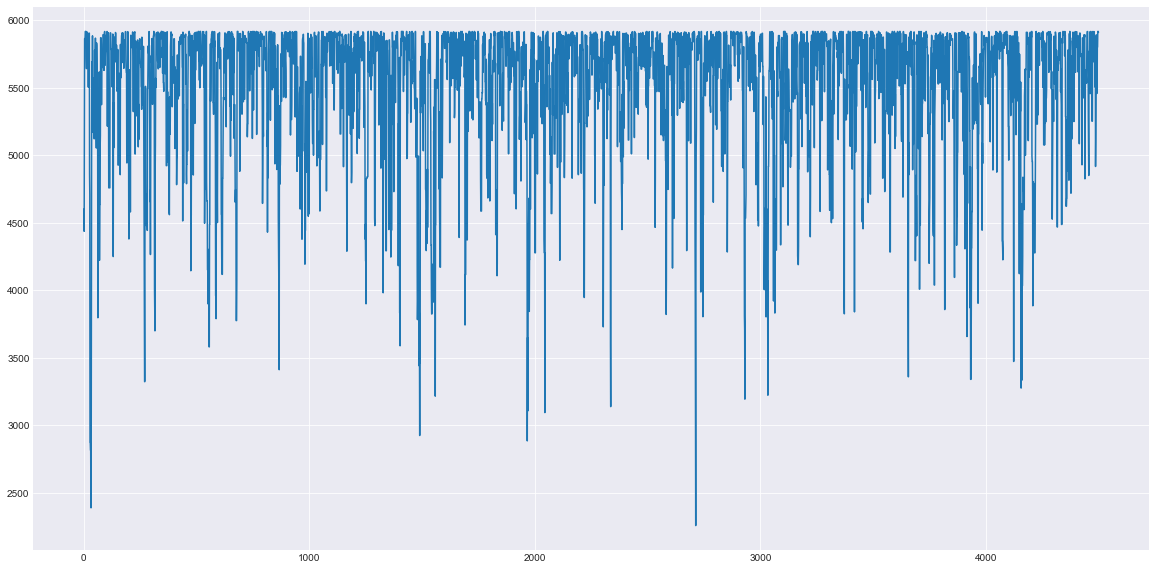

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=range(len(wtd_evid)), y=wtd_evid, ax=ax)

We are plotting the weighted evidence at each step in the chain. The x axis is the index in the chain, and the weighted evidence is the y axis.

### (B)
Consider a different choice for the h(θ) in Equation 7.8. To do this, we’ll leave
it as a beta function, but change the choice of its a and b values. Find where a and b are
specified in the R program (near the end, just before wtdEvid is defined) and type in a=1 and
b=1 instead. Now select (i.e., highlight with the cursor) the portion of the program from the
new a and b definitions, through the computation of wtdEvid, and the new plot command.
Run the selection, and save the resulting plot.

N(pro) = 4500 ; N(acc) / N(pro) = 0.711
p(D) = 3.140e-04


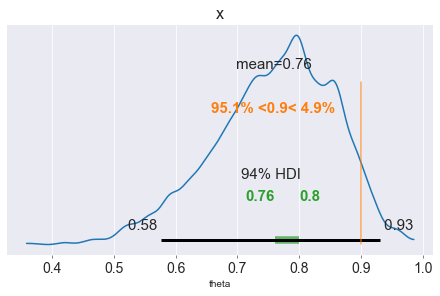

In [46]:
data_coin_flips = np.repeat([1, 0], [11, 3])  # 11 heads, 3 tail
traj_length = 5000
burn_in = int(np.ceil(0.1 * traj_length))
start = 0.5

accepted_traj, n_accepted, n_rejected = generate_random_walk(
    data_coin_flips,
    traj_length=traj_length,
    burn_in=burn_in,
    start=start,
    mean=0,
    stdev=0.1,
    random_state=4745
)

wtd_evid = plot_random_walk(data_coin_flips, accepted_traj, n_accepted, n_rejected, a=1, b=1)

<AxesSubplot:>

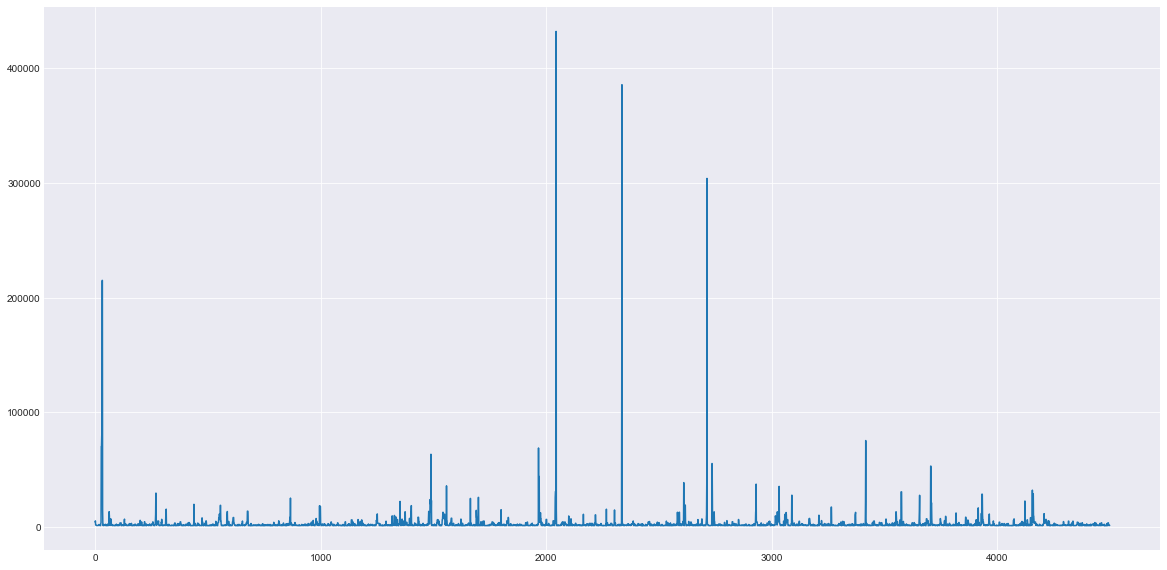

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=range(len(wtd_evid)), y=wtd_evid, ax=ax)

### (C)
Repeat, but this time with a=10 and b=10.

N(pro) = 4500 ; N(acc) / N(pro) = 0.711
p(D) = 2.877e-04


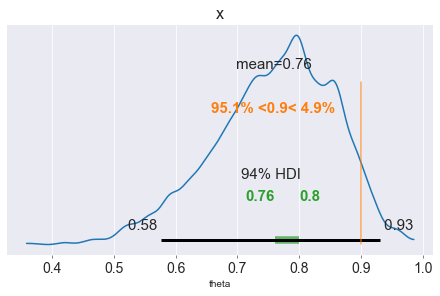

In [49]:
data_coin_flips = np.repeat([1, 0], [11, 3])  # 11 heads, 3 tail
traj_length = 5000
burn_in = int(np.ceil(0.1 * traj_length))
start = 0.5

accepted_traj, n_accepted, n_rejected = generate_random_walk(
    data_coin_flips,
    traj_length=traj_length,
    burn_in=burn_in,
    start=start,
    mean=0,
    stdev=0.1,
    random_state=4745
)

wtd_evid = plot_random_walk(data_coin_flips, accepted_traj, n_accepted, n_rejected, a=10, b=10)

<AxesSubplot:>

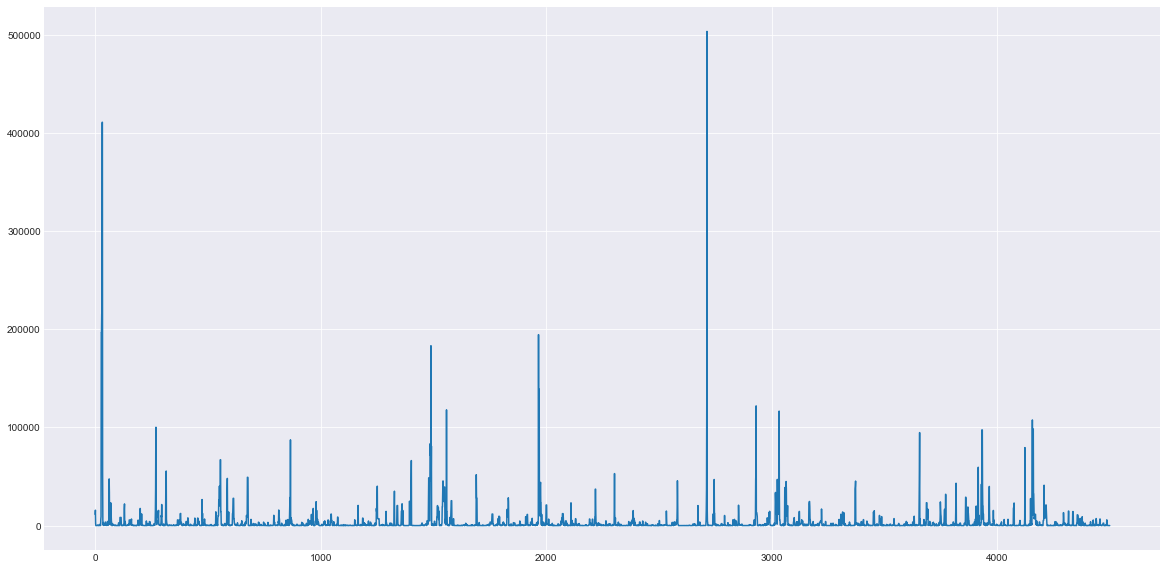

In [50]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=range(len(wtd_evid)), y=wtd_evid, ax=ax)

Larger maximums.

### (D)
For which values of a and b are the values of wtdEvid most stable across the random
walk? Which values of a and b would produce the most stable estimate of p(D)?

N(pro) = 4500 ; N(acc) / N(pro) = 0.711
p(D) = 1.803e-04


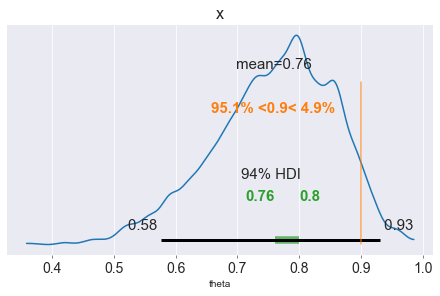

In [53]:
data_coin_flips = np.repeat([1, 0], [11, 3])  # 11 heads, 3 tail
traj_length = 5000
burn_in = int(np.ceil(0.1 * traj_length))
start = 0.5

accepted_traj, n_accepted, n_rejected = generate_random_walk(
    data_coin_flips,
    traj_length=traj_length,
    burn_in=burn_in,
    start=start,
    mean=0,
    stdev=0.1,
    random_state=4745
)

wtd_evid = plot_random_walk(data_coin_flips, accepted_traj, n_accepted, n_rejected, a=11, b=3)

<AxesSubplot:>

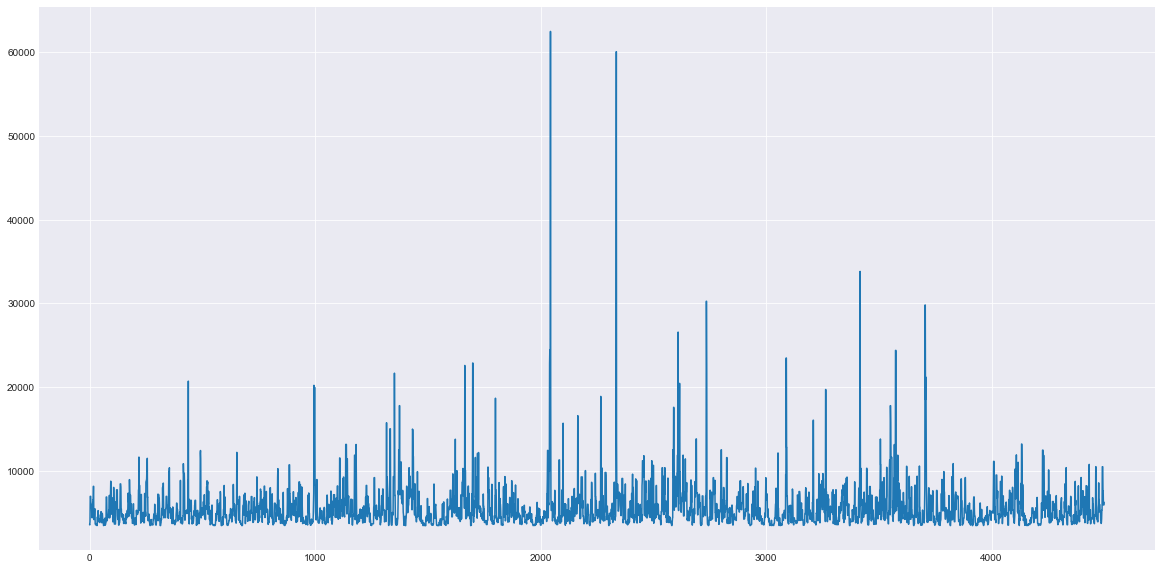

In [54]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=range(len(wtd_evid)), y=wtd_evid, ax=ax)

The most stable a and b values are the ones that are similar to the actual posterior. In this case 11, 3.

## Exercise 7.5
**[Purpose: Explore the use of BUGS, and consider model comparison.]**  
Suppose there
are three people with different beliefs about a coin. One person (M1) believes that the coin
is biased toward tails; we’ll model this person’s beliefs as a uniform distribution over θ
values between 0 and .4. The second person (M2) believes that the coin is approximately
fair; we’ll model this person’s beliefs as a uniform distribution between .4 and .6. The third
person (M3) believes that the coin is biased toward heads; we’ll model this person’s beliefs
as a uniform distribution over θ values between .6 and 1.0. We won’t favor any person
a priori, and therefore we start by assuming that p(M1) = p(M2) = p(M3) = 1/3. We
now flip the coin 14 times and observe 11 heads. Use BUGS to determine the evidences
for the three models. Hints: For each person, compute p(D) by adapting the program
BernBetaBugsFull.R of Section 7.4.1 in two steps. First, modify the model specification
so that the prior is uniform over the limited range, instead of beta. Appendix I of the
OpenBUGS User Manual (see Section 7.4) explains how to specify uniform distributions in
BUGS. Second, include a new section at the end of the BUGS program that will compute
p(D). Do this by copying the last section of the program BernMetropolisTemplate.R that
computes p(D), and pasting it onto the end of your BUGS program, and making additional
necessary changes so that the output of BUGS can be processed by the newly added code.
In particular, before the newly added code, you’ll have to include these lines:  
acceptedTraj = thetaSample  
meanTraj = mean( thetaSample )  
sdTraj = sd( thetaSample )  

In [64]:
def visualize(trace, y, prior_func):
    # create an array with the posterior sample
    theta_sample = trace['theta']

    fig, ax = plt.subplots(1, 2)
    ax[0].plot(theta_sample[:500], np.arange(500), marker='o', color='skyblue')
    ax[0].set_xlim(0, 1)
    ax[0].set_xlabel(r'$\theta$')
    ax[0].set_ylabel('Position in Chain')

    pm.plot_posterior(theta_sample, ax=ax[1], color='skyblue');
    ax[1].set_xlabel(r'$\theta$');

    # Posterior prediction:
    # For each step in the chain, use posterior theta to flip a coin:
    y_pred = np.zeros(len(theta_sample))
    for i, p_head in enumerate(theta_sample):
        y_pred[i] = np.random.choice([0, 1], p=[1 - p_head, p_head])

    # Jitter the 0,1 y values for plotting purposes:
    y_pred_jittered = y_pred + np.random.uniform(-.05, .05, size=len(theta_sample))

    # Now plot the jittered values:
    plt.figure()
    plt.plot(theta_sample[:500], y_pred_jittered[:500], 'C1o')
    plt.xlim(-.1, 1.1)
    plt.ylim(-.1, 1.1)
    plt.xlabel(r'$\theta$')
    plt.ylabel('y (jittered)')

    mean_y = np.mean(y_pred)
    mean_theta = np.mean(theta_sample)

    plt.plot(mean_y, mean_theta, 'k+', markersize=15)
    plt.annotate('mean(y) = %.2f\nmean($\\theta$) = %.2f' %
        (mean_y, mean_theta), xy=(mean_y, mean_theta))
    plt.plot([0, 1], [0, 1], linestyle='--')

    # plt.savefig('BernBetaPyMCPost.png')
    plt.show()

    accepted_traj = theta_sample
    mean_traj = np.mean(theta_sample)
    std_traj = np.std(theta_sample, axis=0)
    my_data = y

    a =   mean_traj   * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)
    b = (1 - mean_traj) * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)

    wtd_evid = beta.pdf(accepted_traj, a, b) / (bern_metropolis_template.likelihood(accepted_traj, my_data) * prior_func(accepted_traj))
    p_data = 1 / np.mean(wtd_evid)
    print(f'P(D) = {p_data}')

In [73]:
def test_uniform_distribution(fr, to):
    # Generate the data
    y = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])  # 11 heads and 3 tails

    with pm.Model() as model:
        # define the prior
        # theta = pm.Beta('theta', 1., 1.)  # prior
        theta = pm.Uniform('theta', fr, to)
        # define the likelihood
        yb = pm.Bernoulli('y', p=theta, observed=y)

        # Generate a MCMC chain
        trace = pm.sample(1000)


    def prior_func(theta):
        if not isinstance(theta, np.ndarray):
            theta = np.array([theta])
        prior = uniform.pdf(x=theta, loc=fr, scale=to-fr)
        prior[(theta < 0) | (theta > 1)] = 1
        return prior if len(prior) > 1 else prior[0]


    visualize(trace, y, prior_func)

<ipython-input-73-f59d5db8af3a>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


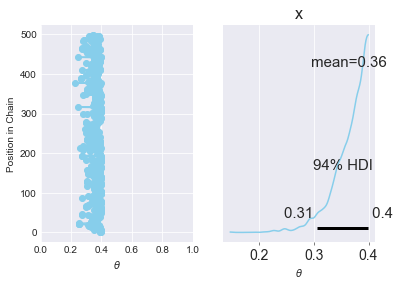

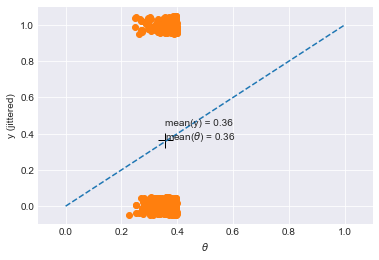

p_data=9.837264576601867e-07


In [74]:
test_uniform_distribution(0.0, 0.4)

<ipython-input-73-f59d5db8af3a>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


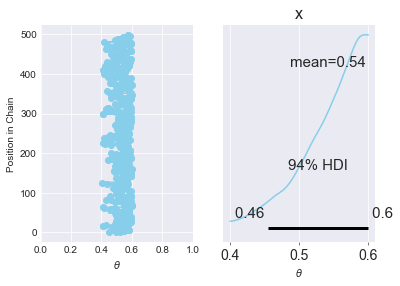

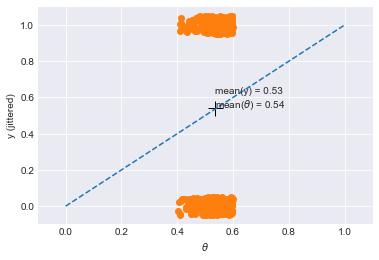

p_data=8.879915712303132e-05


In [75]:
test_uniform_distribution(0.4, 0.6)

<ipython-input-73-f59d5db8af3a>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.7156653597379143, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7059331884479682, but should be close to 0.8. Try to increase the number of tuning steps.


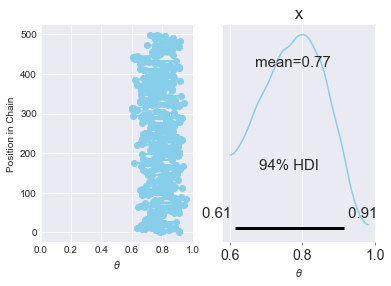

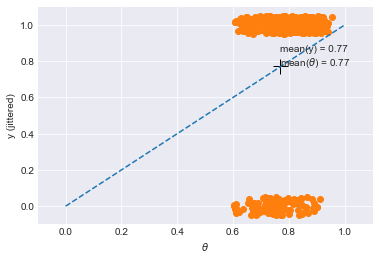

p_data=0.0004283811394833289


In [76]:
test_uniform_distribution(0.6, 1.0)

We observe that the model with uniform distribution [0.6, 1.0] has the largest P(D), so it is preferred.